## Paso 0: Instalo las dependencias

In [1]:
!pip install cplex docplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import string

#Cplex en python
from docplex.mp.model import Model
import docplex.mp.solution as Solution

## Paso 1: Obtengo la información de los bancos

### Obtengo las distancias entre bancos

In [3]:
distances = pd.read_csv('distancias.csv', header=None)
banks = ['0'] + list(string.ascii_uppercase)[:len(distances)-1]
distances.columns = banks
distances.columns 
distances.index = banks
distances

,0,A,B,C,D,E,F,G,H,I,J
0,0,80,88,19,30,43,21,58,87,83,7
A,80,0,32,14,3,88,92,55,18,42,70
B,88,32,0,92,3,11,46,28,43,75,64
C,19,14,92,0,91,42,23,100,41,38,35
D,30,3,3,91,0,41,31,35,18,94,84
E,43,88,11,42,41,0,79,66,22,48,61
F,21,92,46,23,31,79,0,85,32,93,84
G,58,55,28,100,35,66,85,0,90,100,13
H,87,18,43,41,18,22,32,90,0,42,70
I,83,42,75,38,94,48,93,100,42,0,60


### Obtengo la ganancia/ perdida que da cada banco

In [4]:
capital = pd.read_csv('ganancias.csv', header=None)
capital.index = banks[1:]
capital

,0
A,20
B,-30
C,40
D,15
E,-20
F,-25
G,10
H,-20
I,20
J,5


Seteo MAX_DINERO a un numero arbitriario y M a un numero grande

In [5]:
MAX_DINERO = int(capital.max()*1.5)
MAX_DINERO

60

In [6]:
M = int(capital.abs().sum())
M

205

## Paso 2: Grafico la posición relativa de los bancos usando el algoritmo MDS

Esta representación no es perfecta ya que las distancias
son inventadas por lo que hay inconsistencias.

In [7]:
# Perform MDS to estimate the positions of the banks
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
positions = mds.fit_transform(distances)

# Print the estimated positions of the banks
dist = dict()

for i in range(distances.shape[0]):
  label = distances.index[i]
  x = positions[i,0]
  y = positions[i,1]
  dist[label] = (x, y)

dist

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


{'0': (17.222959549628523, -34.38319065606164),
 'A': (6.271839281996156, 24.09313035793905),
 'B': (-33.576711320905204, 5.612163773911987),
 'C': (35.94278032870703, 3.403241075201985),
 'D': (-19.18159648969577, 1.7182971431380714),
 'E': (-29.307533912365965, 18.442715108349866),
 'F': (36.16034712909028, -18.357078966625235),
 'G': (-36.28580571286944, -36.211518815063926),
 'H': (-2.0556004435025126, 28.306360537066304),
 'I': (27.104117341829852, 49.066822702195665),
 'J': (-2.2947957519129556, -41.690942260052154)}

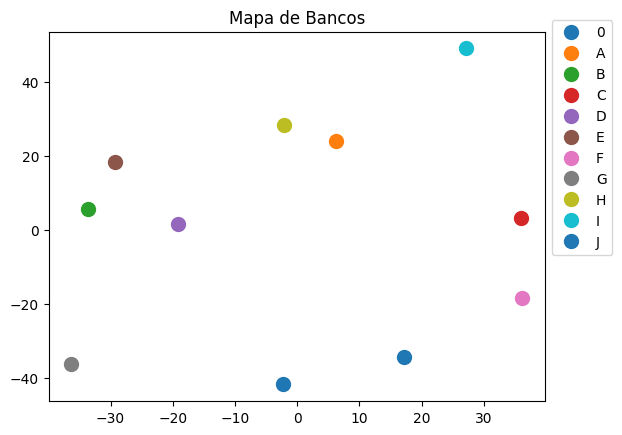

In [8]:
# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Mapa de Bancos")

# Show the plot
plt.show()

## Paso 3: Creo el modelo

In [9]:
model = Model('TSP', log_output=True)

### Variables

In [10]:
def U_name(key):
  return "U_" + banks[key]

In [11]:
u = model.continuous_var_list(range(1, len(banks)), 1, len(banks)-1, name=U_name)

In [12]:
Yij_duplas = [(i, j) for i in banks for j in banks if i != j]
Yij = model.binary_var_dict(Yij_duplas, name='Y')

Se resuelve con el metodo 3 ya que los otros 2 ya estan resueltos en CPLEX \
$-M * (1-Y_{ij}) <= C_i + cte_j -C_j <= (1-Y_{ij}) * M$

In [13]:
def C_name(key):
  return "C_" + banks[key]

In [14]:
Ci = model.continuous_var_list(range(0, len(banks)), 0, MAX_DINERO, name=C_name)

### Subject to

In [15]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if i == b) == 1, ctname=f"sumatoriaSalidaDa1_{b}")

In [16]:
for b in banks:
  model.add_constraint(model.sum(Yij[(i, j)] for i,j in Yij_duplas if j == b) == 1, ctname=f"sumatoriaEntradaDa1_{b}")

In [17]:
N = len(banks) -1
N

10

In [18]:
for i in range(0, N):
  for j in range(0, N):
    if (i == j): continue
    rest = model.add_constraint(u[i] - u[j] + N * Yij[(banks[i+1],banks[j+1])] <= N - 1, \
                         'U_' + str(i+1) + '_'+ str(j+1))

In [19]:
rest

docplex.mp.LinearConstraint[U_10_9](-U_I+U_J+10Y_J_I,LE,9)

Creo que copie la formula mal en el cuaderno si la pueden cambiar

$-M * (1-Y_{ij}) <= C_i + cte_j -C_j <= (1-Y_{ij}) * M$ \
$-M +M Y_{ij} <= C_i + cte_j -C_j <= M -MY_{ij}$ \
$M Y_{ij}-M<= C_i + cte_j -C_j <= M -MY_{ij}$ \

Que se divide en dos para el software \
1. \
$M Y_{ij} - M <= C_i + cte_j -C_j $ \
$M Y_{ij} - C_i + C_j <= cte_j +M $ \

2. \
$ C_i + cte_j -C_j <= M -MY_{ij} $ \
$ MY_{ij} + C_i -C_j <= M - cte_j $ \


In [20]:
for i in range(0, N+1):
  for j in range(0, N+1):
    if i == j: continue
    if j == 0:continue
    cte_j = int(capital.loc[banks[j]])
    #1
    model.add_constraint((M * Yij[ (banks[i], banks[j]) ] - Ci[i] + Ci[j]) <= (M + cte_j),
                         ctname = "C_" + banks[i] + "_" + banks[j] + "_1")
    #2
    model.add_constraint((M * Yij[ (banks[i], banks[j]) ] + Ci[i] - Ci[j]) <= (M - cte_j),
                         ctname = "C_" + banks[i] + "_" + banks[j] + "_2")

In [21]:
model.add_constraint(Ci[0] == 0)

docplex.mp.LinearConstraint[](C_0,EQ,0)

### Funcional

In [22]:
model.minimize(model.sum(distances[i[0]][i[1]] * Yij[i] for i in Yij_duplas))

### Resumen del modelo

In [23]:
print(model.statistics)

 - number of variables: 131
   - binary=110, integer=0, continuous=21
 - number of constraints: 313
   - linear=313


In [24]:
print(model.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: 80 Y_0_A + 88 Y_0_B + 19 Y_0_C + 30 Y_0_D + 43 Y_0_E + 21 Y_0_F + 58 Y_0_G
      + 87 Y_0_H + 83 Y_0_I + 7 Y_0_J + 80 Y_A_0 + 32 Y_A_B + 14 Y_A_C + 3 Y_A_D
      + 88 Y_A_E + 92 Y_A_F + 55 Y_A_G + 18 Y_A_H + 42 Y_A_I + 70 Y_A_J
      + 88 Y_B_0 + 32 Y_B_A + 92 Y_B_C + 3 Y_B_D + 11 Y_B_E + 46 Y_B_F
      + 28 Y_B_G + 43 Y_B_H + 75 Y_B_I + 64 Y_B_J + 19 Y_C_0 + 14 Y_C_A
      + 92 Y_C_B + 91 Y_C_D + 42 Y_C_E + 23 Y_C_F + 100 Y_C_G + 41 Y_C_H
      + 38 Y_C_I + 35 Y_C_J + 30 Y_D_0 + 3 Y_D_A + 3 Y_D_B + 91 Y_D_C + 41 Y_D_E
      + 31 Y_D_F + 35 Y_D_G + 18 Y_D_H + 94 Y_D_I + 84 Y_D_J + 43 Y_E_0
      + 88 Y_E_A + 11 Y_E_B + 42 Y_E_C + 41 Y_E_D + 79 Y_E_F + 66 Y_E_G
      + 22 Y_E_H + 48 Y_E_I + 61 Y_E_J + 21 Y_F_0 + 92 Y_F_A + 46 Y_F_B
      + 23 Y_F_C + 31 Y_F_D + 79 Y_F_E + 85 Y_F_G + 32 Y_F_H + 93 Y_F_I
      + 84 Y_F_J + 58 Y_G_0 + 55 Y_G_A + 28 Y_G_B + 100 Y_G_C + 35 Y_G_D
      + 66 Y_G_

## Paso 4: Resuelvo con CPLEX

In [25]:
solution = model.solve()

Version identifier: 22.1.1.0 | 2023-02-11 | 22d6266e5
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 9 rows and 5 columns.
MIP Presolve modified 384 coefficients.
Reduced MIP has 304 rows, 126 columns, and 1046 nonzeros.
Reduced MIP has 106 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.52 ticks)
Probing time = 0.00 sec. (0.50 ticks)
Cover probing fixed 0 vars, tightened 13 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 9 rows and 0 columns.
MIP Presolve modified 308 coefficients.
Reduced MIP has 295 rows, 126 columns, and 1024 nonzeros.
Reduced MIP has 106 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.64 ticks)
Probing time = 0.00 sec. (0.46 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Clique table members: 151.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, usin

In [26]:
model.get_solve_status() # 2 = TODO OK

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [27]:
details = model.get_solve_details()
details.print_information()

status  = integer optimal solution
time    = 0.264296 s.
problem = MILP
columns = 131
iterations=207
gap     = 0%


In [28]:
solution.get_objective_value()

243.0

In [29]:
final_values = solution.as_df()
final_values

,name,value
0,U_A,4.0
1,U_B,8.0
2,U_C,1.0
3,U_D,3.0
4,U_E,7.0
5,U_F,2.0
6,U_G,9.0
7,U_H,5.0
8,U_I,6.0
9,U_J,10.0


## Paso 5: Grafico la solución

Creo las conexiones

In [30]:
final_values.iloc[N:2*N+1]

,name,value
10,Y_0_C,1.0
11,Y_A_H,1.0
12,Y_B_G,1.0
13,Y_C_F,1.0
14,Y_D_A,1.0
15,Y_E_B,1.0
16,Y_F_D,1.0
17,Y_G_J,1.0
18,Y_H_I,1.0
19,Y_I_E,1.0


In [31]:
nombres_bancos= [
  'Banco Porteño',
  'Banco Del Plata',
  'Banco De Los Andes',
  'Banco Plural',
  'Banco Del Norte',
  'Banco Pampeano',
  'Banco Cooperativo',
  'Banco Sol',
  'Banco República',
  'Banco Vientos del Sur',
]

In [32]:
orden = final_values.iloc[0:N].copy()
orden.name = nombres_bancos
orden.sort_values(by="value", inplace=True)
orden

,name,value
2,Banco De Los Andes,1.0
5,Banco Pampeano,2.0
3,Banco Plural,3.0
0,Banco Porteño,4.0
7,Banco Sol,5.0
8,Banco República,6.0
4,Banco Del Norte,7.0
1,Banco Del Plata,8.0
6,Banco Cooperativo,9.0
9,Banco Vientos del Sur,10.0


In [33]:
def obtener_bancos(row):
  bancos = row["name"].split("_")
  return bancos[1], bancos[2]

In [34]:
# Define the connections between the banks
# Sería el recorrido del camión
connections = final_values.iloc[N:2*N+1]
connections = connections.apply(obtener_bancos, axis=1)
connections = list(connections)
connections

[('0', 'C'),
 ('A', 'H'),
 ('B', 'G'),
 ('C', 'F'),
 ('D', 'A'),
 ('E', 'B'),
 ('F', 'D'),
 ('G', 'J'),
 ('H', 'I'),
 ('I', 'E'),
 ('J', '0')]

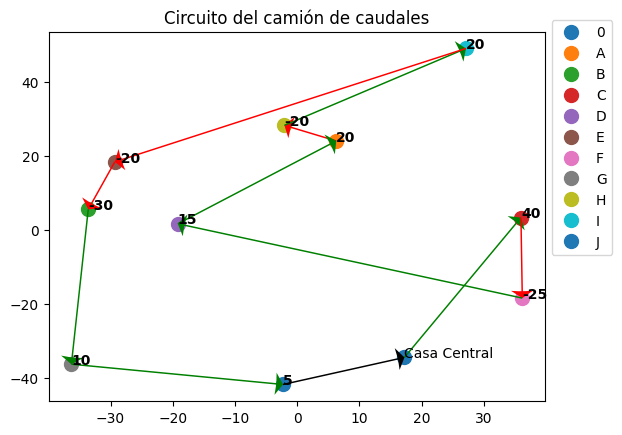

In [35]:
casa_central = banks[0]

# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Plot the connections as arrows
for connection in connections:
  x1, y1 = dist[connection[0]]
  x2, y2 = dist[connection[1]]
  dx, dy = x2 - x1, y2 - y1
  
  if connection[1] == casa_central:
    color = 'black'
  else:
    cambio = int(capital.loc[connection[1]])
    if cambio > 0:
      color = 'green'
    else:
      color = 'red'
  
  ax.quiver(x1, y1, dx, dy,
            angles='xy', scale_units='xy',
            scale=1, width=0.003,
            headwidth=15, color=color,
            zorder=3)

# Annotate the Casa Central
ax.annotate('Casa Central', dist[casa_central])

# Annotate the capital
for b in banks[1:]:
  ax.annotate(int(capital.loc[b]), dist[b], weight="bold")

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Circuito del camión de caudales")

# Show the plot
plt.show()